# CONVOLUTIONAL NEURAL NETWORK GROUP PROJECT

## TEAM REIPAPO GROUP
##### Craig T Chipendo R204740C
##### Cladius Mutavirwa R207523C
##### Lynn Zigara R207669D
##### Kevin Gopito R198132W

## Import Library

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN"))


['catsdogs.ipynb', 'dog-vs-cat-clssification.ipynb', 'model.h5', 'model1_catsVSdogs_10epoch.h5', 'model1_catsVSdogs_10epoch.zip', 'team_reipapo.ipynb', 'test1', 'test1.zip', 'train', 'train.zip']


# Define Constants

In [4]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# DESCRIPTION OF THE DATASET


The training archive contains 25000 images of dogs and cats.The classification model will classify wether images contain a dog or a cat.

QN Explain the choice of the size of the image

we have chosen the image sizes of more than 128px to allow the CNN model to learn more complex features in the images

# Prepare Traning Data

In [5]:
filenames = os.listdir("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/train/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

## EXPLORATORY DATA ANALYSIS

In [6]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [7]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

### See Total In count

<Axes: >

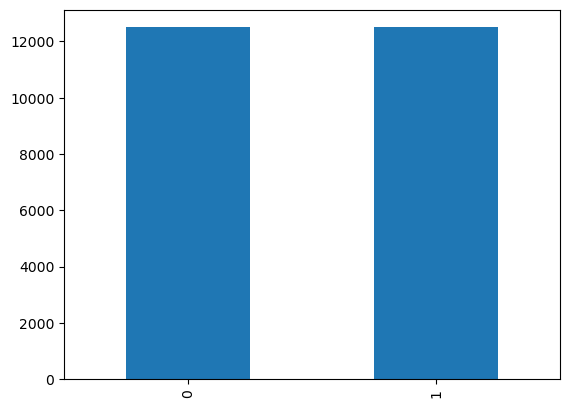

In [8]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

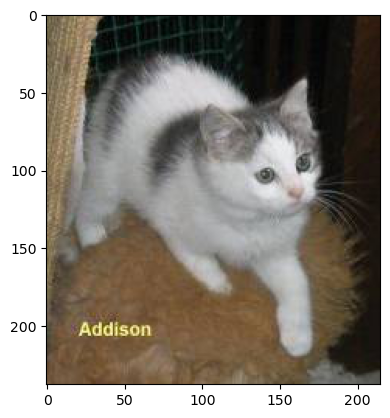

In [10]:
sample = random.choice(filenames)
image = load_img("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/train/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [13]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

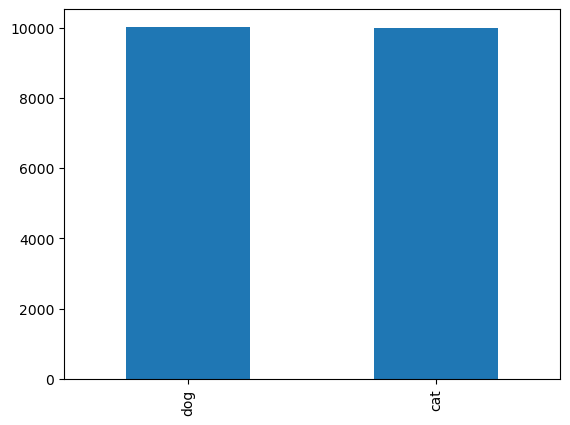

In [18]:
train_df['category'].value_counts().plot.bar()

<Axes: >

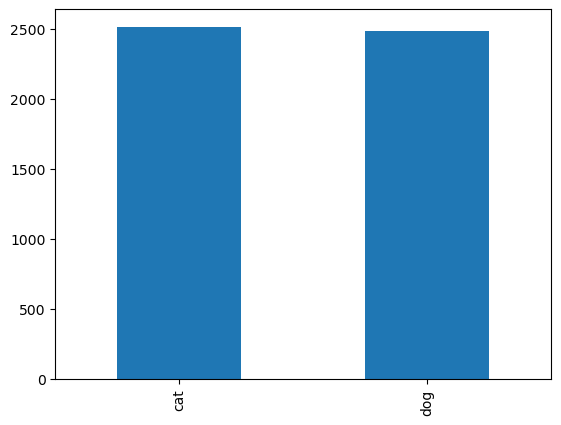

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


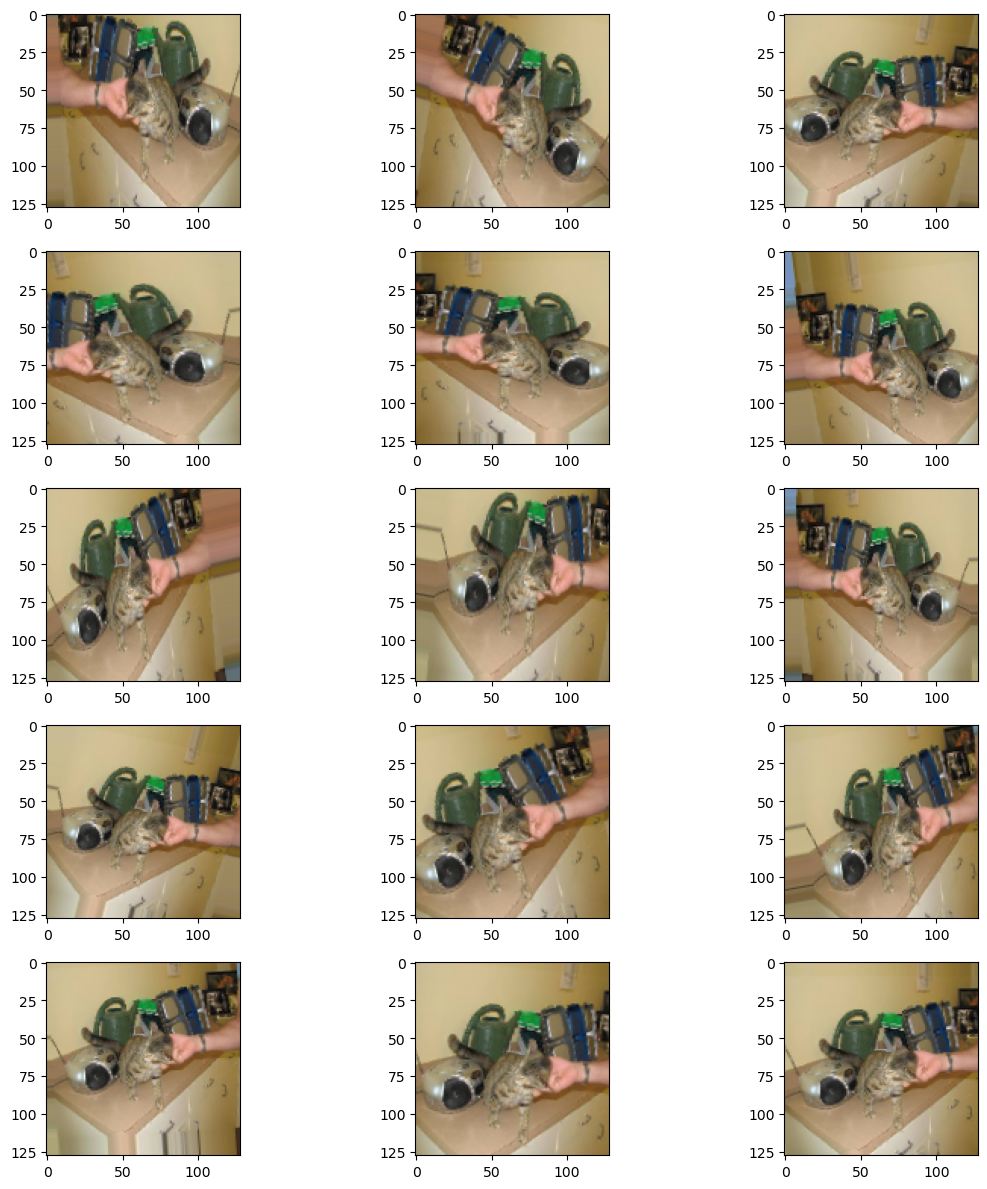

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [25]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\Tanaka\AppData\Local\Temp\ipykernel_18416\2960438613.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
1333/1333 [==============================] - 944s 706ms/step - loss: 0.7374 - accuracy: 0.6349 - val_loss: 0.6033 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 2/20
1333/1333 [==============================] - 933s 700ms/step - loss: 0.5496 - accuracy: 0.7283 - val_loss: 0.4919 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 3/20
1333/1333 [==============================] - 937s 703ms/step - loss: 0.4989 - accuracy: 0.7636 - val_loss: 0.5831 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 4/20
1333/1333 [==============================] - 923s 692ms/step - loss: 0.4561 - accuracy: 0.7910 - val_loss: 0.4043 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 5/20
1333/1333 [==============================] - 889s 667ms/step - loss: 0.4339 - accuracy: 0.8042 - val_loss: 0.3998 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 6/20
1333/1333 [==============================] - 902s 676ms/step - loss: 0.4155 - accuracy: 0.8134 - val_loss: 0.3498 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 7/20
1333/1333 [============

# Save Model

In [79]:
import pickle

# Save CNN model to file
filename = 'team_reipapoo.sav'
pickle.dump(model, open(filename, 'wb'))

In [26]:
model.save_weights("team_reipapo.h5")

# Virtualize Training

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


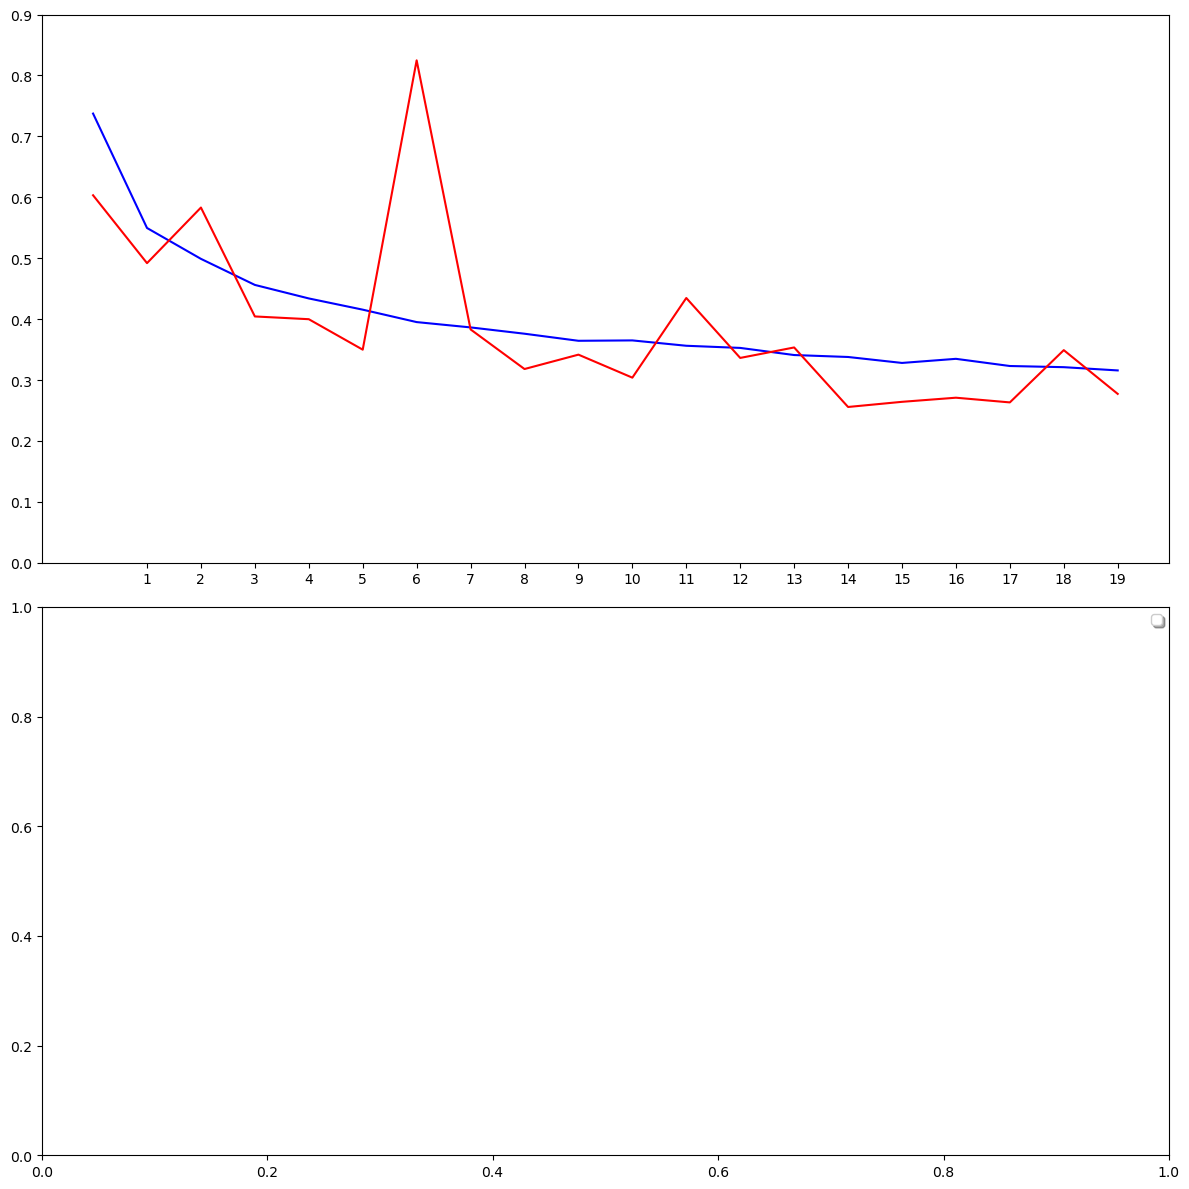

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

#ax2.plot(history.history['acc'], color='b', label="Training accuracy")
#ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
#ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = os.listdir("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\Tanaka\AppData\Local\Temp\ipykernel_18416\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [32]:
test_df

filename  category
0          1.jpg         1
1         10.jpg         0
2        100.jpg         0
3       1000.jpg         1
4      10000.jpg         1
...          ...       ...
12495   9995.jpg         0
12496   9996.jpg         1
12497   9997.jpg         1
12498   9998.jpg         0
12499   9999.jpg         1

[12500 rows x 2 columns]

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

<Axes: >

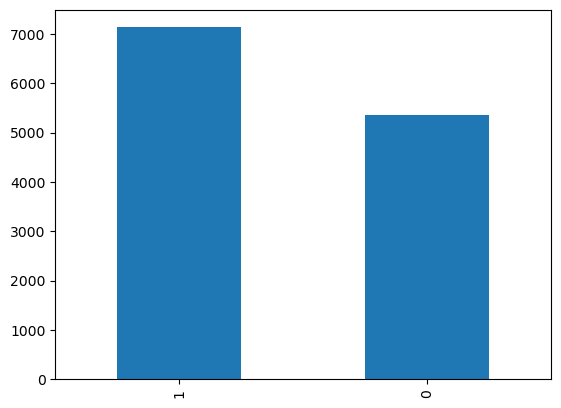

In [35]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

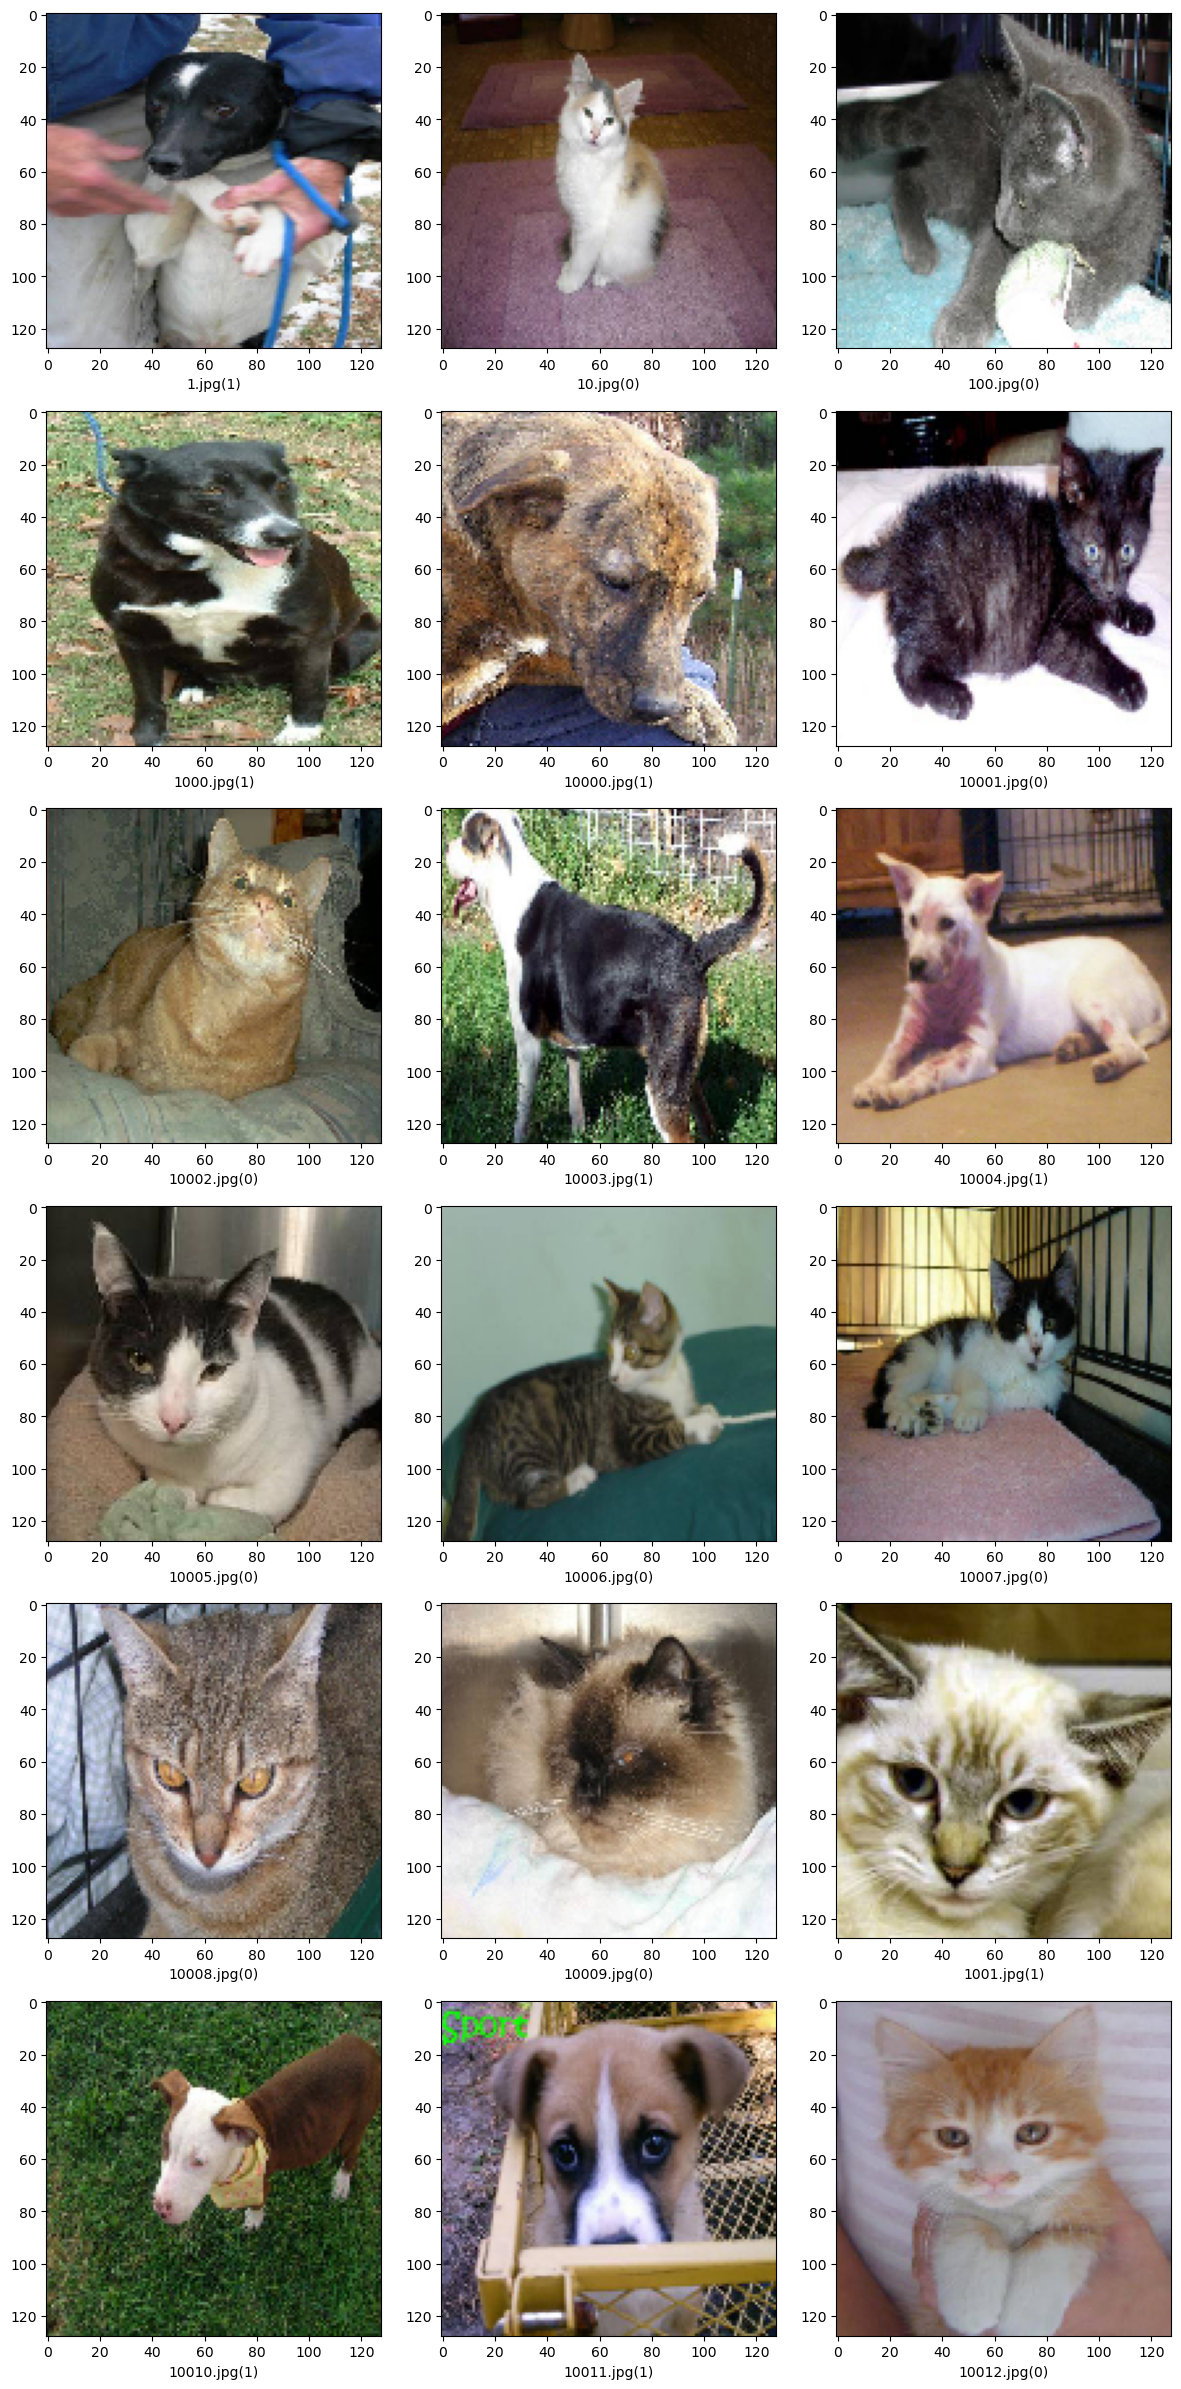

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [38]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [39]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [40]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("C:/Users/Tanaka/Documents/TANAKA/BSc HDSC/PROJECTS/python/CNN/test1/5.jpg")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
#pred=model.predict_classes([im])[0]
#print(pred,results[pred])

In [41]:
predict_x=model.predict([im])[0]
classes_x=np.argmax(predict_x,axis=0)

1/1 [==============================] - 0s 296ms/step


In [42]:
print(classes_x,results[classes_x])

0 cat


# Submission

In [43]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('team_reipapo.csv', index=False)